In [379]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as py 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf , plot_predict
import statsmodels.tsa.api as smt 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.metrics import mean_absolute_error, mean_squared_error  
from arch import arch_model
py.style.use('seaborn')

C:\Users\10830\AppData\Local\Temp\ipykernel_15332\941339242.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  py.style.use('seaborn')


**資料整理**

In [380]:
df1 = pd.read_csv("C:\\Users\\10830\\Downloads\\pcr策略程式範例\\pcr策略程式範例\\atm_option_settle.csv")
df1.columns = ['Date','Call_BW','Call_W','Put_BW','Put_W']

df2 = pd.read_csv("C:\\Users\\10830\\Downloads\\^TWII (1).csv")
# df2 = df2[['Date','Close']]
# df2.columns = ['Date','Close']

df = pd.merge(df1, df2, on='Date')
df


,Date,Call_BW,Call_W,Put_BW,Put_W,Open,High,Low,Close,Adj Close,Volume
0,2020/1/2,68.0,102.0,56.0,0.1,12026.50000,12110.74023,12026.23047,12100.48047,12100.48047,2023800
1,2020/1/3,NaN,52.0,NaN,56.0,12167.44043,12197.63965,12023.59961,12110.42969,12110.42969,2572900
2,2020/1/6,NaN,5.4,NaN,147.0,12035.70996,12040.08008,11953.36035,11953.36035,11953.36035,2345200
3,2020/1/7,NaN,0.6,NaN,225.0,11961.96973,11986.03027,11822.40039,11880.32031,11880.32031,2338400
4,2020/1/8,136.0,0.1,99.0,260.0,11818.75977,11899.66992,11777.45020,11817.09961,11817.09961,2428800
...,...,...,...,...,...,...,...,...,...,...,...
884,2023/8/24,NaN,433.0,NaN,12.5,16651.02930,16822.35938,16651.02930,16770.86914,16770.86914,3988000
885,2023/8/25,NaN,167.0,NaN,67.0,16708.52930,16708.52930,16481.58008,16481.58008,16481.58008,3217200
886,2023/8/28,NaN,182.0,NaN,23.5,16498.85938,16582.96094,16498.85938,16509.25977,16509.25977,3052400
887,2023/8/29,NaN,291.0,NaN,1.3,16528.49023,16627.69922,16495.75977,16623.65039,16623.65039,2649500


**建立ARIMA時間序列模型** 
* 原始資料視覺化 
* 平穩性檢驗 
* ACF與PACF圖 
* 樣本內模型建立 
* 樣本外模型建立

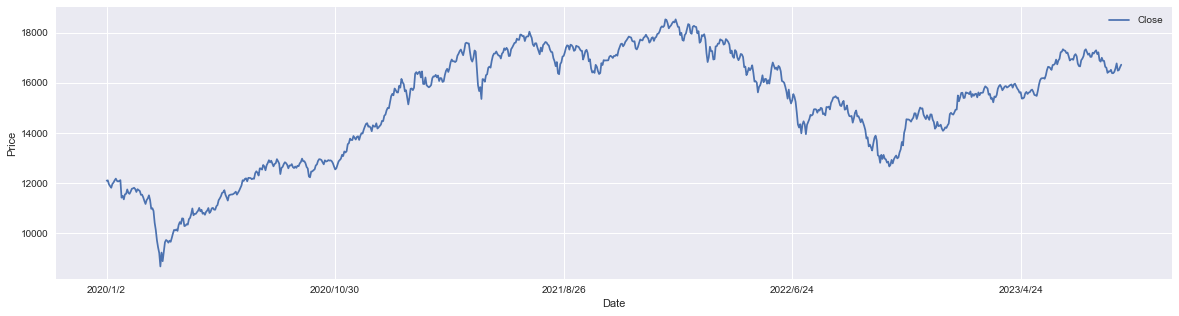

,Close
Date,
2020/1/2,12100.48047
2020/1/3,12110.42969
2020/1/6,11953.36035
2020/1/7,11880.32031
2020/1/8,11817.09961
...,...
2023/8/24,16770.86914
2023/8/25,16481.58008
2023/8/28,16509.25977


In [381]:
arima_data = df[['Date','Close']]
arima_data = arima_data.set_index('Date')
arima_data.plot(figsize=(20,5)) 
settlements = pd.read_csv("C:\\Users\\10830\\Downloads\\settlements.csv")
py.ylabel("Price") 
py.show()

arima_data

In [344]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test\n===============================================================") 
    dftest = adfuller(timeseries, autolag="AIC") 
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p=value", "#Lags Used", "Number of Observations Used"]) 
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")  
    #寫個自動判斷式
    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")
        
adf_test(arima_data)

Results of Dickey-Fuller Test
Test Statistic                  -1.383246
p=value                          0.590281
#Lags Used                       0.000000
Number of Observations Used    888.000000
Criterical Value (1%)           -3.437735
Criterical Value (5%)           -2.864800
Criterical Value (10%)          -2.568506
dtype: float64
The data is non-stationary, so do differencing!


Results of Dickey-Fuller Test
Test Statistic                 -28.633066
p=value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    887.000000
Criterical Value (1%)           -3.437744
Criterical Value (5%)           -2.864804
Criterical Value (10%)          -2.568508
dtype: float64
The data is stationary. (Criterical Value 1%)


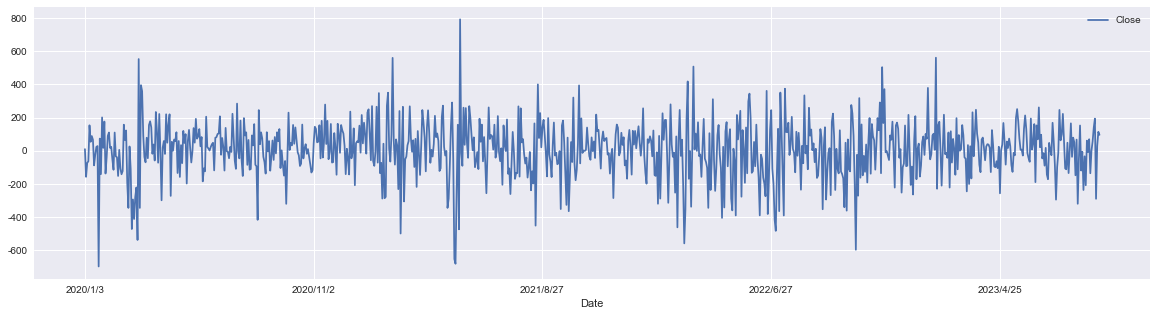

In [345]:
diff_1 = arima_data - arima_data.shift(1) 
diff_1 = diff_1.dropna() 
diff_1.plot(figsize=(20,5), label="diff_1")
py.legend() 

adf_test(diff_1)

c:\veighna_studio\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


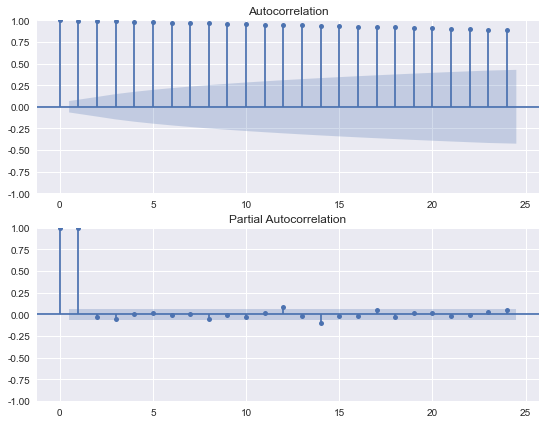

In [346]:
# ACF (Autocorrelation Function)
# PACF (Partial Autocorrelation Function) 

f = py.figure(facecolor='white', figsize=(9,7))  
ax1 = f.add_subplot(211) 
plot_acf(arima_data, lags=24, ax=ax1) 
ax2 = f.add_subplot(212) 
plot_pacf(arima_data, lags=24, ax=ax2) 
py.rcParams['axes.unicode_minus'] = False 
py.show() 


In [382]:
def arima_AIC(data, p=3, d=3, q=3):
    a = 0
    b = 0 
    c = 0
    best_AIC = ["pdq", 20000] 
    L = len(data) 
    AIC = [] 
    name = [] 
    for i in range(p):
        for j in range(1,d):
            for k in range(q):
                model = ARIMA(data, order=(i,j,k)) 
                fitted = model.fit() 
                AIC.append(fitted.aic) 
                name.append(f"ARIMA({i},{j},{k})")
                # print(f"ARIMA({i},{j},{k}) : AIC={fitted.aic}") 
                if fitted.aic < best_AIC[1]:
                    best_AIC[0] = f"ARIMA({i},{j},{k})" 
                    best_AIC[1] = fitted.aic 
                    a = i 
                    b = j 
                    c = k 

    # print("================================================================================================") 
    # print(f"This best model is {best_AIC[0]} based on argmin AIC.")
    # py.figure(figsize=(12,5))
    # py.bar(name, AIC)
    # py.bar(best_AIC[0], best_AIC[1], color = "red")
    # py.xticks(rotation=30)
    # py.title("AIC")
    # py.savefig("Arima AIC")
    # py.show() 

    return a, b, c

In [ ]:
forecast = [] 

for index in arima_data.index:
    if index in settlements['Date'].to_list() and index!=settlements['Date'].to_list()[-1] and settlements['Date'].to_list().index(index)>=12:
        print(index)
        next_settlement = settlements['Date'].to_list()[settlements['Date'].to_list().index(index) + 1] #下一個結算日的日期
        period = arima_data.loc[index:next_settlement].shape[0] - 1 #計算下一周的期數
        start_forecast_date = settlements['Date'].to_list()[settlements['Date'].to_list().index(index)-12] #用前三個月的數據來預測下一周的價格
        p, d, q = arima_AIC(arima_data.loc[start_forecast_date:index], p=3, d=3, q=3) 
        model = ARIMA(arima_data.loc[start_forecast_date:index], order=(p,d,q)).fit() 
        fc = model.forecast(period, alpha=0.05).to_list()[-1] # 下一次結算日的預測價格 
        print(str(index)+" "+str(fc)) #第一次預測從2020/4/1開始
        forecast.append(fc)

forecast

**建立ARIMA-Garch時間序列模型**

In [383]:
arima_data['Ret'] = np.log(arima_data['Close']) - np.log(arima_data['Close'].shift(1)) 
arima_data = arima_data.dropna()

forecast = [] 

for index in arima_data.index:
    if index in settlements['Date'].to_list() and index!=settlements['Date'].to_list()[-1] and settlements['Date'].to_list().index(index)>=13:
        print(index)
        next_settlement = settlements['Date'].to_list()[settlements['Date'].to_list().index(index) + 1] #下一個結算日的日期
        period = arima_data.loc[index:next_settlement].shape[0] - 1 #計算下一周的期數
        start_forecast_date = settlements['Date'].to_list()[settlements['Date'].to_list().index(index)-12] #用前三個月的數據來預測下一周的價格
        p, d, q = arima_AIC(arima_data['Ret'].loc[start_forecast_date:index], p=3, d=3, q=3) 
        model = ARIMA(arima_data['Ret'], order=(p,d,q)).fit() 
        fc = model.forecast(period, alpha=0.05).to_list() # 到下一次結算日期間的預測收益率
        resid = model.resid 
        garch = arch_model(resid, vol='GARCH', p=1, q=1).fit() 
        prediction = np.sqrt(garch.forecast(horizon=period).variance.values[-1:][0]) # 到下一次結算日前期間的波動度
        upper_fc = fc + prediction 
        lower_fc = fc - prediction 

        upper_fc_price = arima_data['Close'].loc[index]
        lower_fc_price = arima_data['Close'].loc[index]
        for i in range(0, period):
            upper_fc_price = upper_fc_price * (1+upper_fc[i])
            lower_fc_price = lower_fc_price * (1+lower_fc[i])
        fc_price = (upper_fc_price + lower_fc_price) / 2
        forecast.append(fc_price)

print(forecast) 
        



2020/4/8


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2020/4/15


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 305644589.7274315
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4263873138751.131
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5168510613425240.0
Iteration:      4,   Func. Count:     44,   Neg. LLF: -2749.0458465829133
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2749.045844383651
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4
2020/4/22


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.1534339987868224e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 13407635763.898848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2632.552153698061
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
2020/4/29


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.1534339987868224e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 13407635763.898848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2632.552153698061
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
2020/5/6


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.1534339987868224e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 13407635763.898848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2632.552153698061
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
2020/5/13


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/5/20


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/5/27


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.1534339987868224e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 13407635763.898848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2632.552153698061
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
2020/6/3


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.1534339987868224e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 13407635763.898848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2632.552153698061
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
2020/6/10


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2020/6/17


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/6/24


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/7/1


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/7/8


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/7/15


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/7/22


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/7/29


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/8/5


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\veighna_studio\lib\site-packages

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/8/12


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/8/19


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/8/26


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/9/2


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/9/9


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\veighna_studio\lib\site-packages

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/9/16


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\veighna_studio\lib\site-packages

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/9/23


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/9/30


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/10/7


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/10/14


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/10/21


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/10/28


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/11/4


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/11/11


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/11/18


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2020/11/25


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/12/2


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/12/9


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/12/16


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2020/12/23


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 305644589.7274315
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4263873138751.131
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5168510613425240.0
Iteration:      4,   Func. Count:     44,   Neg. LLF: -2749.0458465829133
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2749.045844383651
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4
2020/12/30


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 234388454.74175298
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2217433282941.9414
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2319177344529216.0
Iteration:      4,   Func. Count:     45,   Neg. LLF: 3454.6865604077984
Iteration:      5,   Func. Count:     54,   Neg. LLF: 17250521274.978195
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4870486042.915997
Iteration:      7,   Func. Count:     77,   Neg. LLF: -2748.325056370402
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2748.3250555825616
            Iterations: 11
            Function evaluations: 77
            Gradient evaluations: 7
2021/1/6


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 234388454.74175298
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2217433282941.9414
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2319177344529216.0
Iteration:      4,   Func. Count:     45,   Neg. LLF: 3454.6865604077984
Iteration:      5,   Func. Count:     54,   Neg. LLF: 17250521274.978195
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4870486042.915997
Iteration:      7,   Func. Count:     77,   Neg. LLF: -2748.325056370402
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2748.3250555825616
            Iterations: 11
            Function evaluations: 77
            Gradient evaluations: 7
2021/1/13


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 234388454.74175298
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2217433282941.9414
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2319177344529216.0
Iteration:      4,   Func. Count:     45,   Neg. LLF: 3454.6865604077984
Iteration:      5,   Func. Count:     54,   Neg. LLF: 17250521274.978195
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4870486042.915997
Iteration:      7,   Func. Count:     77,   Neg. LLF: -2748.325056370402
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2748.3250555825616
            Iterations: 11
            Function evaluations: 77
            Gradient evaluations: 7
2021/1/20


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 234388454.74175298
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2217433282941.9414
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2319177344529216.0
Iteration:      4,   Func. Count:     45,   Neg. LLF: 3454.6865604077984
Iteration:      5,   Func. Count:     54,   Neg. LLF: 17250521274.978195
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4870486042.915997
Iteration:      7,   Func. Count:     77,   Neg. LLF: -2748.325056370402
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2748.3250555825616
            Iterations: 11
            Function evaluations: 77
            Gradient evaluations: 7
2021/1/27


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/2/3


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/2/17


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/2/24


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/3/3


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/3/10


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/3/17


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/3/24


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/3/31


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/4/7


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/4/14


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/4/21


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/4/28


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/5/5


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/5/12


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249255213.9876034
Iteration:      2,   Func. Count:     18,   Neg. LLF: 392215439390.9375
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.697315406582
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
2021/5/19


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/5/26


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/6/2


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/6/9


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/6/16


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/6/23


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/6/30


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/7/7


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/7/14


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/7/21


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\veighna_studio\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001392. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/7/28


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/8/4


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 305644589.7274315
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4263873138751.131
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5168510613425240.0
Iteration:      4,   Func. Count:     44,   Neg. LLF: -2749.0458465829133
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2749.045844383651
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4
2021/8/11


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/8/18


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/8/25


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/9/1


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\veighna_studio\lib\site-packages

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2021/9/8


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2021/9/15


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/9/22


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2021/9/29


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/10/6


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2021/10/13


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/10/20


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/10/27


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/11/3


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/11/10


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 265579014.06737226
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1735265537388.5874
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1650435469297222.5
Iteration:      4,   Func. Count:     45,   Neg. LLF: 21850617.266917683
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.4925364392298
            Iterations: 6
            Function evaluations: 52
            Gradient evaluations: 4
2021/11/17


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 265579014.06737226
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1735265537388.5874
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1650435469297222.5
Iteration:      4,   Func. Count:     45,   Neg. LLF: 21850617.266917683
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.4925364392298
            Iterations: 6
            Function evaluations: 52
            Gradient evaluations: 4
2021/11/24


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/12/1


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 265579014.06737226
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1735265537388.5874
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1650435469297222.5
Iteration:      4,   Func. Count:     45,   Neg. LLF: 21850617.266917683
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.4925364392298
            Iterations: 6
            Function evaluations: 52
            Gradient evaluations: 4
2021/12/8


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/12/15


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/12/22


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2021/12/29


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/1/5


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/1/12


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249255213.9876034
Iteration:      2,   Func. Count:     18,   Neg. LLF: 392215439390.9375
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.697315406582
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
2022/1/19


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2022/1/26


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/2/7


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/2/9


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/2/16


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/2/23


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/3/2


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/3/9


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/3/16


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/3/23


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/3/30


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/4/6


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/4/13


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/4/20


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/4/27


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/5/4


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/5/11


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/5/18


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/5/25


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/6/1


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/6/8


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/6/15


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/6/22


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/6/29


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/7/6


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\veighna_studio\lib\site-packages

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/7/13


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/7/20


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/7/27


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/8/3


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\veighna_studio\lib\site-packages

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/8/10


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/8/17


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\veighna_studio\lib\site-packages

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/8/24


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/8/31


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/9/7


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\veighna

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/9/14


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/9/21


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\veighna_studio\lib\site-packages

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/9/28


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/10/5


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/10/12


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/10/19


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/10/26


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/11/2


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/11/9


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/11/16


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\veighna_studio\lib\site-packages

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/11/23


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/11/30


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/12/7


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 305644589.7274315
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4263873138751.131
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5168510613425240.0
Iteration:      4,   Func. Count:     44,   Neg. LLF: -2749.0458465829133
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2749.045844383651
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4
2022/12/14


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 305644589.7274315
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4263873138751.131
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5168510613425240.0
Iteration:      4,   Func. Count:     44,   Neg. LLF: -2749.0458465829133
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2749.045844383651
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4
2022/12/21


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2022/12/28


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/1/4


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2023/1/11


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/1/30


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/2/1


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/2/8


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/2/15


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/2/22


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\veighna_studio\lib\site-packages

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/3/1


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/3/8


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\veighna_studio\lib\site-packages

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249255213.9876034
Iteration:      2,   Func. Count:     18,   Neg. LLF: 392215439390.9375
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.697315406582
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
2023/3/15


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/3/22


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2023/3/29


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/4/6


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2023/4/12


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2023/4/19


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2023/4/26


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/5/3


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249255213.9876034
Iteration:      2,   Func. Count:     18,   Neg. LLF: 392215439390.9375
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.697315406582
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
2023/5/10


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/5/17


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/5/24


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 305644589.7274315
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4263873138751.131
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5168510613425240.0
Iteration:      4,   Func. Count:     44,   Neg. LLF: -2749.0458465829133
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2749.045844383651
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4
2023/5/31


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/6/7


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2023/6/14


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2023/6/21


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\veighna_studio\lib\site-packages

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/6/28


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/7/5


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/7/12


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249255213.9876034
Iteration:      2,   Func. Count:     18,   Neg. LLF: 392215439390.9375
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.697315406582
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
2023/7/19


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2023/7/26


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249584972.58864766
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2710195141041.7437
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1864247954747.3323
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3515028765446.0503
Iteration:      5,   Func. Count:     63,   Neg. LLF: 403017.81955231115
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5.108935122475441e+16
Iteration:      7,   Func. Count:     87,   Neg. LLF: 17758794475.97654
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.723288732627
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7
2023/8/2


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 249255213.9876034
Iteration:      2,   Func. Count:     18,   Neg. LLF: 392215439390.9375
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.697315406582
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
2023/8/9


c:\veighna_studio\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/8/16


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
2023/8/23


c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\veighna_studi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 258182737.57087865
Iteration:      2,   Func. Count:     18,   Neg. LLF: 606362964941.8046
Iteration:      3,   Func. Count:     33,   Neg. LLF: 333692035781499.9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2747.5236807391657
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
[10166.597582761155, 10490.998683584228, 10608.280189937695, 11018.901259408733, 11089.143625699093, 10968.241325477735, 10937.68811583492, 11335.81159080335, 11650.218970666663, 11753.835535470404, 11566.195604207573, 11676.870868212616, 11735.488293088656, 12203.537794269334, 12236.286463220098, 12507.447356964905, 12575.333061312063, 12837.379208116643, 12705.067453265867, 12813.654217251524, 12868.454354001444, 12734.29771783147, 12643.128669462525, 13012.317203351176, 12618.360788798722, 12532.999124103095, 12772.131998220899, 12954.709584882025, 12912.5347680574

c:\veighna_studio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\veighna_studio\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001392. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [349]:
print(forecast)

[9603.935358893128, 10660.853965321483, 10603.021051183525, 10255.24871067958, 11088.078391922365, 10882.406273815204, 11055.329685664221, 11001.12540475617, 11131.307391557362, 11563.41720956499, 11956.09084201975, 11712.170831469122, 11772.308082187097, 11852.483767043826, 12333.428733174202, 12379.02845922034, 12632.822012304552, 12702.703755692777, 12973.550429117855, 12832.719416473943, 12940.91781174386, 12977.380487935514, 12798.478962295369, 12453.394786840548, 13103.725579190224, 12573.781047334047, 12541.862061755382, 12796.678912038447, 12975.309807699854, 12604.960285260177, 12754.136896208336, 12900.068297673386, 13319.90186994175, 14179.085506890722, 13876.452708335784, 14123.909428635236, 14669.830972713997, 14502.921525305443, 14407.034898717398, 15129.107107001788, 15477.129706224508, 16366.061496986378, 16076.13498125191, 15958.889017950598, 15912.757286318772, 16619.125244764775, 16410.288287444506, 16447.967440271415, 16085.248696851428, 16382.964393889606, 16029.41

**回測數據整理**

In [384]:
df = df.set_index('Date')

In [385]:
df

,Call_BW,Call_W,Put_BW,Put_W,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,
2020/1/2,68.0,102.0,56.0,0.1,12026.50000,12110.74023,12026.23047,12100.48047,12100.48047,2023800
2020/1/3,NaN,52.0,NaN,56.0,12167.44043,12197.63965,12023.59961,12110.42969,12110.42969,2572900
2020/1/6,NaN,5.4,NaN,147.0,12035.70996,12040.08008,11953.36035,11953.36035,11953.36035,2345200
2020/1/7,NaN,0.6,NaN,225.0,11961.96973,11986.03027,11822.40039,11880.32031,11880.32031,2338400
2020/1/8,136.0,0.1,99.0,260.0,11818.75977,11899.66992,11777.45020,11817.09961,11817.09961,2428800
...,...,...,...,...,...,...,...,...,...,...
2023/8/24,NaN,433.0,NaN,12.5,16651.02930,16822.35938,16651.02930,16770.86914,16770.86914,3988000
2023/8/25,NaN,167.0,NaN,67.0,16708.52930,16708.52930,16481.58008,16481.58008,16481.58008,3217200
2023/8/28,NaN,182.0,NaN,23.5,16498.85938,16582.96094,16498.85938,16509.25977,16509.25977,3052400


In [386]:
i = 0
df['FClose'] = pd.Series() 
for index in df.index:
    if index in settlements['Date'].to_list() and index>'2020/4/1': 
        df['FClose'].loc[index] = forecast[i] 
        i = i + 1 

df

C:\Users\10830\AppData\Local\Temp\ipykernel_15332\2514957938.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['FClose'] = pd.Series()
C:\Users\10830\AppData\Local\Temp\ipykernel_15332\2514957938.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FClose'].loc[index] = forecast[i]


,Call_BW,Call_W,Put_BW,Put_W,Open,High,Low,Close,Adj Close,Volume,FClose
Date,,,,,,,,,,,
2020/1/2,68.0,102.0,56.0,0.1,12026.50000,12110.74023,12026.23047,12100.48047,12100.48047,2023800,NaN
2020/1/3,NaN,52.0,NaN,56.0,12167.44043,12197.63965,12023.59961,12110.42969,12110.42969,2572900,NaN
2020/1/6,NaN,5.4,NaN,147.0,12035.70996,12040.08008,11953.36035,11953.36035,11953.36035,2345200,NaN
2020/1/7,NaN,0.6,NaN,225.0,11961.96973,11986.03027,11822.40039,11880.32031,11880.32031,2338400,NaN
2020/1/8,136.0,0.1,99.0,260.0,11818.75977,11899.66992,11777.45020,11817.09961,11817.09961,2428800,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023/8/24,NaN,433.0,NaN,12.5,16651.02930,16822.35938,16651.02930,16770.86914,16770.86914,3988000,NaN
2023/8/25,NaN,167.0,NaN,67.0,16708.52930,16708.52930,16481.58008,16481.58008,16481.58008,3217200,NaN
2023/8/28,NaN,182.0,NaN,23.5,16498.85938,16582.96094,16498.85938,16509.25977,16509.25977,3052400,NaN


In [387]:
df['Strike'] = pd.Series()
def find_nearest_multiple(number):
    return round(number / 50) * 50
for index in df.index:
    if index in settlements['Date'].to_list():
        strike = find_nearest_multiple(df.loc[index]['Close']) 
        df['Strike'].loc[index] = strike 

C:\Users\10830\AppData\Local\Temp\ipykernel_15332\3168781636.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['Strike'] = pd.Series()
C:\Users\10830\AppData\Local\Temp\ipykernel_15332\3168781636.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Strike'].loc[index] = strike


In [388]:
df

,Call_BW,Call_W,Put_BW,Put_W,Open,High,Low,Close,Adj Close,Volume,FClose,Strike
Date,,,,,,,,,,,,
2020/1/2,68.0,102.0,56.0,0.1,12026.50000,12110.74023,12026.23047,12100.48047,12100.48047,2023800,NaN,12100.0
2020/1/3,NaN,52.0,NaN,56.0,12167.44043,12197.63965,12023.59961,12110.42969,12110.42969,2572900,NaN,NaN
2020/1/6,NaN,5.4,NaN,147.0,12035.70996,12040.08008,11953.36035,11953.36035,11953.36035,2345200,NaN,NaN
2020/1/7,NaN,0.6,NaN,225.0,11961.96973,11986.03027,11822.40039,11880.32031,11880.32031,2338400,NaN,NaN
2020/1/8,136.0,0.1,99.0,260.0,11818.75977,11899.66992,11777.45020,11817.09961,11817.09961,2428800,NaN,11800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023/8/24,NaN,433.0,NaN,12.5,16651.02930,16822.35938,16651.02930,16770.86914,16770.86914,3988000,NaN,NaN
2023/8/25,NaN,167.0,NaN,67.0,16708.52930,16708.52930,16481.58008,16481.58008,16481.58008,3217200,NaN,NaN
2023/8/28,NaN,182.0,NaN,23.5,16498.85938,16582.96094,16498.85938,16509.25977,16509.25977,3052400,NaN,NaN


**交易策略回測** 
* 先比較預測價格跟strike price 
* 計算option是overvalued還是undervalued 
* 每周定期檢視條件是否達成來決定是否建倉

In [390]:
bt_data = df[59:]
bt_data

,Call_BW,Call_W,Put_BW,Put_W,Open,High,Low,Close,Adj Close,Volume,FClose,Strike
Date,,,,,,,,,,,,
2020/4/8,180.0,565.0,152.0,0.1,10010.63965,10149.75977,9984.660156,10137.46973,10137.46973,3117000,10166.597583,10150.0
2020/4/9,NaN,142.0,NaN,142.0,10173.25977,10246.83984,10092.360350,10119.42969,10119.42969,3058700,NaN,NaN
2020/4/10,NaN,133.0,NaN,99.0,10105.42969,10165.12012,10103.769530,10157.61035,10157.61035,2365200,NaN,NaN
2020/4/13,NaN,82.0,NaN,106.0,10147.55957,10179.40039,10080.650390,10099.21973,10099.21973,2456300,NaN,NaN
2020/4/14,NaN,250.0,NaN,4.4,10130.65039,10344.12988,10130.650390,10332.94043,10332.94043,2847000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023/8/24,NaN,433.0,NaN,12.5,16651.02930,16822.35938,16651.029300,16770.86914,16770.86914,3988000,NaN,NaN
2023/8/25,NaN,167.0,NaN,67.0,16708.52930,16708.52930,16481.580080,16481.58008,16481.58008,3217200,NaN,NaN
2023/8/28,NaN,182.0,NaN,23.5,16498.85938,16582.96094,16498.859380,16509.25977,16509.25977,3052400,NaN,NaN


In [399]:
bt_data['Signal'] = pd.Series() 
for index in bt_data.index:
    if index in settlements['Date'].to_list():
        if bt_data['FClose'].loc[index]>bt_data['Strike'].loc[index] and (bt_data['FClose'].loc[index]-bt_data['Strike'].loc[index])>bt_data['Call_BW'].loc[index]:
            bt_data['Signal'].loc[index] = 1
        elif bt_data['FClose'].loc[index]<bt_data['Strike'].loc[index] and (bt_data['Strike'].loc[index]-bt_data['FClose'].loc[index])>bt_data['Put_BW'].loc[index]:
            bt_data['Signal'].loc[index] = -1
        else:
            bt_data['Signal'].loc[index] = 0
            

bt_data['Signal'] = bt_data['Signal'].fillna(0)
bt_data

C:\Users\10830\AppData\Local\Temp\ipykernel_15332\2842088662.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  bt_data['Signal'] = pd.Series()
C:\Users\10830\AppData\Local\Temp\ipykernel_15332\2842088662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt_data['Signal'] = pd.Series()
C:\Users\10830\AppData\Local\Temp\ipykernel_15332\2842088662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt_data['Signal'].loc[index] = 1
C:\Users\10830\A

,Call_BW,Call_W,Put_BW,Put_W,Open,High,Low,Close,Adj Close,Volume,FClose,Strike,Signal
Date,,,,,,,,,,,,,
2020/4/8,180.0,565.0,152.0,0.1,10010.63965,10149.75977,9984.660156,10137.46973,10137.46973,3117000,10166.597583,10150.0,1.0
2020/4/9,NaN,142.0,NaN,142.0,10173.25977,10246.83984,10092.360350,10119.42969,10119.42969,3058700,NaN,NaN,0.0
2020/4/10,NaN,133.0,NaN,99.0,10105.42969,10165.12012,10103.769530,10157.61035,10157.61035,2365200,NaN,NaN,0.0
2020/4/13,NaN,82.0,NaN,106.0,10147.55957,10179.40039,10080.650390,10099.21973,10099.21973,2456300,NaN,NaN,0.0
2020/4/14,NaN,250.0,NaN,4.4,10130.65039,10344.12988,10130.650390,10332.94043,10332.94043,2847000,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023/8/24,NaN,433.0,NaN,12.5,16651.02930,16822.35938,16651.029300,16770.86914,16770.86914,3988000,NaN,NaN,0.0
2023/8/25,NaN,167.0,NaN,67.0,16708.52930,16708.52930,16481.580080,16481.58008,16481.58008,3217200,NaN,NaN,0.0
2023/8/28,NaN,182.0,NaN,23.5,16498.85938,16582.96094,16498.859380,16509.25977,16509.25977,3052400,NaN,NaN,0.0


2020/4/8 buy call, cost  180.0
2020/4/15 close call, pnl 117.20996000000014
2020/4/15 buy call, cost  198.0
2020/4/22 close call, pnl -198.0
2020/4/22 buy call, cost  218.0
2020/4/29 close call, pnl 254.2197300000007
2020/4/29 buy call, cost  150.0
2020/5/6 close call, pnl -125.01952999999958
2020/5/6 buy call, cost  160.0
2020/5/13 close call, pnl 28.269529999999577
2020/5/13 buy call, cost  131.0
2020/5/20 close call, pnl -131.0
2020/5/20 buy call, cost  135.0
2020/5/27 close call, pnl -20.33984000000055
2020/5/27 buy call, cost  139.0
2020/6/3 close call, pnl 181.16015999999945
2020/6/3 buy call, cost  141.0
2020/6/10 close call, pnl 279.16015999999945
2020/6/10 buy call, cost  127.0
2020/6/17 close call, pnl -127.0
2020/6/17 buy call, cost  217.0
2020/6/24 close call, pnl -106.33007999999973
2020/6/24 buy call, cost  191.0
2020/7/1 close call, pnl -137.58007999999973
2020/7/1 buy call, cost  164.0
2020/7/8 close call, pnl 306.19043000000056
2020/7/8 buy call, cost  138.0
2020/7/15 

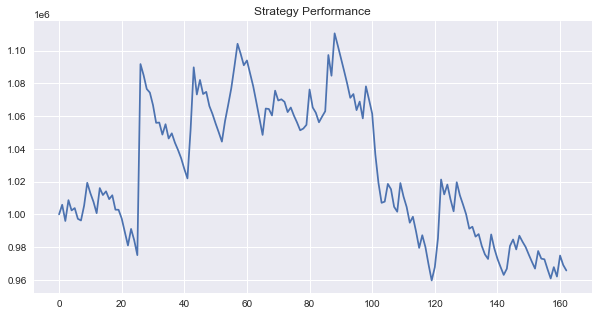

In [400]:
position = 0
cost = []
strike = [] 
pnl = [] 
trade = [] 
for index in bt_data.index:

    if index in settlements['Date'].to_list():
        # 有持倉(call)且下周持續看漲
        if position==1 and bt_data['Signal'].loc[index]==1:
            # 平倉
            if strike[-1] < bt_data['Close'].loc[index]:
                pnl.append(bt_data['Close'].loc[index]-strike[-1]-cost[-1]) 
            else:
                pnl.append(-cost[-1])
            
            print(str(index)+" "+"close call, "+ "pnl", pnl[-1]) # 日期, 動作, 損益
            
            # 建倉
            cost.append(bt_data['Call_BW'].loc[index]) 
            strike.append(bt_data['Strike'].loc[index])
            trade.append('call')
            print(str(index)+" "+"buy call, "+ "cost ", bt_data['Call_BW'].loc[index]) # 日期, 動作, 權利金成本
        
        # 有持倉(put)但下周看漲
        elif position==-1 and bt_data['Signal'].loc[index]==1:
            # 平倉
            if strike[-1] > bt_data['Close'].loc[index]:
                pnl.append(strike[-1]-bt_data['Close'].loc[index]-cost[-1])
            else:
                pnl.append(-cost[-1])
            
            print(str(index)+" "+"close put, "+ "pnl", pnl[-1]) # 日期, 動作, 損益
            
            # 建倉
            cost.append(bt_data['Call_BW'].loc[index]) 
            strike.append(bt_data['Strike'].loc[index])
            trade.append('call') 
            position = 1 
            print(str(index)+" "+"buy call, "+ "cost ", bt_data['Call_BW'].loc[index]) # 日期, 動作, 權利金成本
        
        # 沒持倉但下周看漲
        elif bt_data['Signal'].loc[index]==1 and position==0:
            position = 1
            cost.append(bt_data['Call_BW'].loc[index]) 
            strike.append(bt_data['Strike'].loc[index]) 
            trade.append('call')
            print(str(index)+" "+"buy call, "+ "cost ", bt_data['Call_BW'].loc[index]) # 日期, 動作, 權利金成本

        # 有持倉(call)但下周看跌
        elif bt_data['Signal'].loc[index]==-1 and position==1:
            #平倉
            if strike[-1] < bt_data['Close'].loc[index]:
                pnl.append(bt_data['Close'].loc[index]-strike[-1]-cost[-1]) 
            else:
                pnl.append(-cost[-1])
            
            print(str(index)+" "+"close call, "+ "pnl", pnl[-1]) # 日期, 動作, 損益

            #建倉
            cost.append(bt_data['Put_BW'].loc[index])
            strike.append(bt_data['Strike'].loc[index])
            
            position = -1 #改變持倉情況
            trade.append('put')
            print(str(index)+" "+"buy put, "+ "cost ", bt_data['Put_BW'].loc[index]) # 日期, 動作, 權利金成本
        
        # 有持倉(put)且下周看跌
        elif bt_data['Signal'].loc[index]==-1 and position==-1:
            #平倉
            if strike[-1] > bt_data['Close'].loc[index]:
                pnl.append(strike[-1]-bt_data['Close'].loc[index]-cost[-1]) 
            else:
                pnl.append(-cost[-1])
            
            print(str(index)+" "+"close put, "+ "pnl", pnl[-1]) # 日期, 動作, 損益

            #建倉
            cost.append(bt_data['Put_BW'].loc[index])
            strike.append(bt_data['Strike'].loc[index])
            trade.append('put')
            print(str(index)+" "+"buy put, "+ "cost ", bt_data['Put_BW'].loc[index]) # 日期, 動作, 權利金成本
            
        # 沒有持倉且下周看跌
        elif bt_data['Signal'].loc[index]==-1 and position==0:
            #建倉
            cost.append(bt_data['Put_BW'].loc[index])
            strike.append(bt_data['Strike'].loc[index]) 

            position = -1
            trade.append('put')
            print(str(index)+" "+"buy put, "+ "cost ", bt_data['Put_BW'].loc[index]) # 日期, 動作, 權利金成本
        
        # 有持倉(call)但下周沒有訊號
        elif bt_data['Signal'].loc[index]==0 and position==1:
            #平倉
            if strike[-1] < bt_data['Close'].loc[index]:
                pnl.append(bt_data['Close'].loc[index]-strike[-1]-cost[-1]) 
            else:
                pnl.append(-cost[-1])
            
            position = 0
            print(str(index)+" "+"close call, "+ "pnl", pnl[-1]) # 日期, 動作, 損益
        
        # 有持倉(put)但下周沒有訊號
        elif bt_data['Signal'].loc[index]==0 and position==-1:
            #平倉
            if strike[-1] > bt_data['Close'].loc[index]:
                pnl.append(strike[-1]-bt_data['Close'].loc[index]-cost[-1]) 
            else:
                pnl.append(-cost[-1]) 
            
            position = 0
            print(str(index)+" "+"close put, "+ "pnl", pnl[-1]) # 日期, 動作, 損益
        
        # 沒有持倉且下周沒有訊號
        elif bt_data['Signal'].loc[index]==0 and position==0:
            position = 0
            print(str(index)+" "+"no position, "+ "no pnl") # 日期, 動作, 損益
        
        else:
            pass 
    
    else:
        pass

equity = [1000000] 
for i in pnl:
    equity.append(equity[-1]+i*50) 

py.figure(figsize=(10,5)) 
py.plot(equity) 
py.title('Strategy Performance')
py.show()


In [394]:
result = pd.DataFrame() 
result['pnl'] = pd.Series(pnl) 
result.to_csv("C:\\Users\\10830\\Desktop\\學校\\碩一上\\選擇權評價\\3m_garch.csv")

In [398]:
bt_data[50:100]

,Call_BW,Call_W,Put_BW,Put_W,Open,High,Low,Close,Adj Close,Volume,FClose,Strike,Signal
Date,,,,,,,,,,,,,
2020/6/18,NaN,235.0,NaN,42.0,11534.20020,11567.41992,11485.38965,11548.33008,11548.33008,3404900,NaN,NaN,0.0
2020/6/19,NaN,231.0,NaN,27.0,11557.26953,11584.87988,11542.37012,11549.86035,11549.86035,4580400,NaN,NaN,0.0
2020/6/22,NaN,230.0,NaN,13.0,11553.91016,11632.87988,11553.91016,11572.92969,11572.92969,2950700,NaN,NaN,0.0
2020/6/23,NaN,260.0,NaN,3.2,11618.41992,11679.40039,11530.84961,11612.36035,11612.36035,3057500,NaN,NaN,0.0
2020/6/24,191.0,302.0,55.0,0.2,11647.86035,11701.23047,11637.79004,11660.66992,11660.66992,2861900,11676.870868,11650.0,0.0
2020/6/29,NaN,65.0,NaN,85.0,11608.79981,11608.79981,11500.65039,11542.62012,11542.62012,2922300,NaN,NaN,0.0
2020/6/30,NaN,102.0,NaN,11.0,11563.59961,11638.00000,11563.59961,11621.24023,11621.24023,2935300,NaN,NaN,0.0
2020/7/1,164.0,203.0,60.0,0.2,11622.63965,11736.38965,11622.63965,11703.41992,11703.41992,2868400,11735.488293,11700.0,0.0
2020/7/2,NaN,276.0,NaN,23.0,11694.09961,11805.20996,11690.95020,11805.13965,11805.13965,3060100,NaN,NaN,0.0
